In [1]:
import pandas as pd
import seaborn as sns

#### Import AFT Data set

##### mentorship

In [2]:
Mtoship = pd.read_csv('neuro.csv')

In [3]:
Mtoship.sample(1)

,Unnamed: 0,CID,MenteeID,MentorID,MentorshipType,Institution,InstitutionMAGID,StartYear,StopYear
22703,27124,33877,16704,3851,2,"University of Wisconsin, Madison",135310074.0,1991,1994


<Axes: xlabel='StopYear', ylabel='Count'>

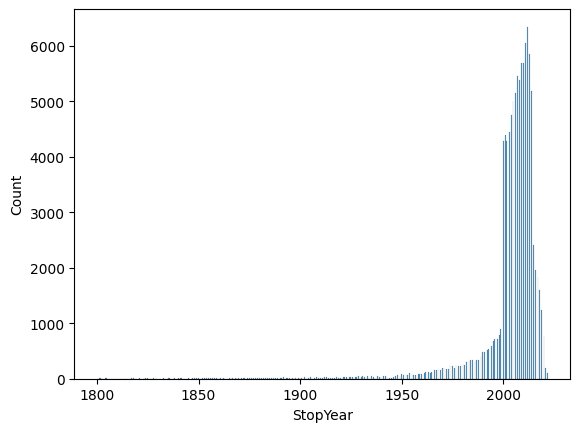

In [4]:
sns.histplot(data=Mtoship, x="StopYear",binrange=[1800,2022])

In [5]:
len(Mtoship[Mtoship.StopYear!=-1])/len(Mtoship)

0.6478100837429905

In [6]:
Mentor_StopYear = Mtoship[['MentorID','StopYear']][Mtoship.StopYear!=-1]

In [7]:
Mentor_StopYear.head(5)

,MentorID,StopYear
0,3,2005
1,3,2006
2,3,2008
3,9,1984
13,3,2006


In [8]:
idx = Mentor_StopYear.groupby(['MentorID'])['StopYear'].transform(min) == Mentor_StopYear['StopYear'] #choose the minimum StopYear 
Mentor_FirstYear = Mentor_StopYear[idx]

In [9]:
Mentor_FirstYear = Mentor_FirstYear.rename(columns={'StopYear':'FirstMenteeYear'})

In [10]:
Mentor_FirstYear.head(5)

,MentorID,FirstMenteeYear
3,9,1984
28,3,2002
61,51,2000
78,52,1990
91,102,1982


In [11]:
len(Mentor_FirstYear)

33709

<Axes: xlabel='FirstMenteeYear', ylabel='Probability'>

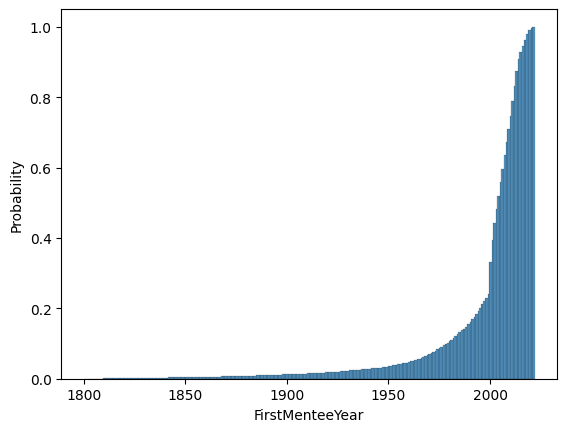

In [12]:
sns.histplot(data=Mentor_FirstYear, x="FirstMenteeYear",binrange=[1800,2022],stat='probability',cumulative=True)

Check the result above

In [13]:
Mentor_StopYear[Mentor_StopYear.MentorID==245]

,MentorID,StopYear
225,245,1990
10087,245,1991
11715,245,2001
14136,245,1991
28842,245,2007
32450,245,1994
32451,245,1992
58189,245,2011
58191,245,2012
58192,245,2012


In [14]:
Mentor_FirstYear.to_csv('Mentor_FirstMenteeYear.csv',index=0)

##### researcher

In [15]:
PeoInfo = pd.read_csv('researcher.csv')

In [16]:
PeoInfo.sample(1)

,PID,FirstName,MiddleName,LastName,Institution,InstitutionMAGID,ResearchArea,ORCID,MAGAuthorID
317827,348895,THOMAS,M,OVER,Texas A & M University,91045830.0,physics,NaN,2.303712e+09


In [17]:
PeoInfo = PeoInfo.rename(columns={'PID':'MentorID'})

In [18]:
Mentor_FirstYear = Mentor_FirstYear.merge(PeoInfo, on='MentorID',how='left')[['MentorID','MAGAuthorID','FirstMenteeYear']]

In [19]:
Mentor_FirstYear = Mentor_FirstYear[~Mentor_FirstYear.MAGAuthorID.isnull()]

In [20]:
Mentor_FirstYear

,MentorID,MAGAuthorID,FirstMenteeYear
0,9,2.952982e+09,1984
1,3,2.110166e+09,2002
2,51,3.321924e+08,2000
3,52,7.025748e+08,1990
4,102,6.939312e+08,1982
...,...,...,...
33704,26878,2.259184e+08,2020
33705,839652,2.107955e+09,2016
33706,154914,2.048983e+09,2014
33707,14788,2.111146e+09,2022


In [21]:
magId = [int(k) for k in list(Mentor_FirstYear.MAGAuthorID)]

In [22]:
from sqlalchemy import create_engine
engine = create_engine("mysql+pymysql://{user}:{pw}@{host}:{port}/{db}?charset=utf8mb4"
                       .format(user="openalex_ym",
                               pw="openalex.ym",
                               host="172.18.18.167",
                               port=3306,
                               db="openalex2022"),
                       )

In [23]:
magId_groups = []
interval = 5000
start_point = 0
while True:
    end_point = start_point + interval
    try:
        temp = magId[start_point:end_point]
        magId_groups.append(temp)
    except:
        temp = magId[start_point:]
        magId_groups.append(temp)
        
    start_point = end_point
    if end_point>len(magId):
        break

In [24]:
print(len(magId_groups))

6


In [25]:
l = len(magId_groups)
for i in range(l):
    temp =  magId_groups[i]
    sql_query = """select authors_ids.author_id, authors_ids.mag 

                    from authors_ids 

                    where authors_ids.mag in {}
                    """.format(tuple(temp))


    data = pd.read_sql(sql_query, con=engine)
    # merge data
    if i==0:
        tp = data
    else:
        tp = pd.concat((tp,data))

data = tp

In [26]:
data = data.rename(columns={'mag':'MAGAuthorID'})

In [27]:
data

,author_id,MAGAuthorID
0,A367921,367921
1,A980010,980010
2,A1121383,1121383
3,A1378751,1378751
4,A2229241,2229241
...,...,...
3298,A3042051828,3042051828
3299,A3043216625,3043216625
3300,A3049095968,3049095968
3301,A3049417342,3049417342


In [28]:
data = data.merge(Mentor_FirstYear,on='MAGAuthorID',how='left')

In [29]:
data = data.rename(columns={'MentorID':'AFTMentorID'})

In [30]:
data

,author_id,MAGAuthorID,AFTMentorID,FirstMenteeYear
0,A367921,367921,2488,2000
1,A980010,980010,12407,1991
2,A1121383,1121383,11355,2009
3,A1378751,1378751,18791,1999
4,A2229241,2229241,27837,2006
...,...,...,...,...
29006,A3042051828,3042051828,16828,2019
29007,A3043216625,3043216625,48602,2014
29008,A3049095968,3049095968,8536,2018
29009,A3049417342,3049417342,372362,2012


In [31]:
data.to_csv('target_author.csv',index=0)